# Multiclass SVM implementations from scratch using sub-gradient descent

This is a pure numpy implementation to understand the inner workings of SVMs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from random import randrange

%load_ext autoreload
%autoreload 2
%matplotlib inline

We use mnist as our dataset. Bare in mind, that we are also dealing with a multi-class classification problem. So we have to consider this as a one vs all classifier.

Let's use tensorflow to download our dataset.

https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html
https://cs231n.github.io/linear-classify/#svm

## Read in data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
n_samples, _, _ = X_train.shape

In [4]:
# We will also make a development set, which is a small subset of
# the training set.
n_dev = 500
mask = np.random.choice(n_samples, n_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

Some helper functions for preprocessing

In [5]:
def one_hot(labels):
    unique_labels = np.unique(labels)
    return (unique_labels == labels[:, np.newaxis]).astype(int)

def preprocess(X_train, y_train, X_test, y_test):
    fac = 255 * 0.99 + 0.01
    X_train = X_train / fac
    X_test = X_test / fac
    X_train = X_train.astype(np.float32) 
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32) 
    y_test = y_test.astype(np.float32)
#     y_train = one_hot(y_train)
#     y_test = one_hot(y_test)
    return X_train, y_train, X_test, y_test

def flatten2d(X):
    return X.reshape(X.shape[0], -1)

### Visualize images

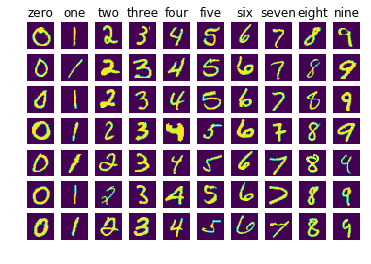

In [6]:
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
n_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Preprocess data

In [7]:
X_train = flatten2d(X_train)
X_test = flatten2d(X_test)
X_dev = flatten2d(X_dev)
# Preprocessing
# X_train, y_train, X_test, y_test = preprocess(X_train, y_train, X_test, y_test)
# mean_image = np.mean(X_train, axis=0)
# X_train = X_train - mean_image
# X_test = X_test - mean_image
# X_dev = X_dev - mean_image
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_dev = y_dev.astype(np.int32)
# y_train = y_train[..., None]
# y_test = y_test[..., None]
print(f"X_train.shape={X_train.shape}")
print(f"X_test.shape={X_test.shape}")
print(f"X_dev.shape={X_dev.shape}")
print(f"y_train.shape={y_train.shape}")
print(f"y_test.shape={y_test.shape}")
print(f"y_dev.shape={y_dev.shape}")

X_train.shape=(60000, 784)
X_test.shape=(10000, 784)
X_dev.shape=(500, 784)
y_train.shape=(60000,)
y_test.shape=(10000,)
y_dev.shape=(500,)


In [8]:
n_samples, n_features = X_train.shape
# n_classes = y_train.shape[1]
n_classes = np.max(y_train) + 1
n_dev = 500
print(f"n_samples={n_samples}, n_features={n_features}")
print(f"n_classes={n_classes}")

n_samples=60000, n_features=784
n_classes=10


Can also substract mean from train and test image

In [9]:
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_test -= mean_image

In [10]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

## Vectorized implementation

In [11]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a[:, None] - b)**2, axis=2))

In [12]:
class NLSVM():
    
    def __init__(self, delta=1., reg=0.001, kernel="rbf", gamma=10., d=2):
        self.delta = delta
        self.reg = reg
        self.gamma = gamma
        self.d = d
        self.kernel = kernel
       
    def loss(self, y, y_pred, w, train=True):
        """Return loss
        """
        n_samples = y.shape[0]
        correct_class_preds = y_pred[np.arange(n_samples), y][:, np.newaxis]
        margin = np.maximum(0, y_pred - correct_class_preds + self.delta)
        margin[np.arange(n_samples), y] = 0
        loss = margin.sum() / n_samples
        # Add regularization
        loss = loss + self.reg * np.sum(w * w)
        if train:
            self.margin = margin
        return loss

    def kernel_eval(self, x1, x2):
        result = None
        if self.kernel == "linear":
            result = np.dot(x1, x2.T) # Linear kernel - same as np.inner(x, x.T)
        if self.kernel == "polynomial":
            result = (1 + np.dot(x1, x2.T))**self.d
        elif self.kernel == "rbf":
            result = np.exp(-self.gamma * euclidean_distance(x1, x2)**2)

        return result

    def forward(self, X1, X2, w, train=True):
        """Perform forward pass
        """
        k = self.kernel_eval(X1, X2)
        if train:
            self.k = k
        return np.dot(k.T, w)
    
    def accuracy(self, y, y_pred):
        if y_pred.ndim > 1:
            y_pred_flatten = np.argmax(y_pred, axis=1)
        else:
            y_pred_flatten = y_pred.copy()
            
        return (y == y_pred_flatten).sum() / y.shape[0]
    
    def backward(self, X, y, w):
        """Perform backprop
        """
        # We create a mask since the gradient of cost-sensitive multiclass loss is -x
        # for correct class and x for other classes
        n_samples = self.margin.shape[0]
        X_mask = np.zeros(self.margin.shape)
        X_mask[self.margin > 0] = 1 # We utilize classes that have greater than 0 margin
        valid_margin_count = X_mask.sum(axis=1) # Count how many classes have margin > 0
        X_mask[np.arange(n_samples), y] = -valid_margin_count
        dW = (np.dot(X.T, X_mask) / n_samples) + 2 * self.reg * w
        return dW

## Analytical gradient check

In [13]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [14]:
co_eff = np.random.randn(X_dev.shape[0], n_classes)
svm = NLSVM()

In [15]:
pred = svm.forward(X_dev, X_dev, co_eff)
loss = svm.loss(y_dev, pred, co_eff)
grad = svm.backward(svm.k, y_dev, co_eff)
def f(w):
    p = svm.forward(X_dev, X_dev, w)
    loss = svm.loss(y_dev, p, w, train=False)
    return loss
    
# f = lambda w: svm.loss(X_dev, y_dev, w, reg=5e1)[0]
grad_numerical = grad_check_sparse(f, co_eff, grad)

numerical: -0.000393 analytic: -0.000393, relative error: 1.010361e-07
numerical: 0.001973 analytic: 0.001973, relative error: 1.352640e-08
numerical: -0.000314 analytic: -0.000314, relative error: 7.369486e-08
numerical: -0.005470 analytic: -0.005470, relative error: 4.280171e-09
numerical: -0.001424 analytic: -0.001424, relative error: 2.676407e-08
numerical: 0.002871 analytic: 0.002871, relative error: 1.065184e-08
numerical: -0.000314 analytic: -0.000314, relative error: 7.369486e-08
numerical: 0.001578 analytic: 0.001578, relative error: 2.768304e-09
numerical: 0.003150 analytic: 0.003150, relative error: 1.904023e-08
numerical: 0.005049 analytic: 0.005049, relative error: 9.411115e-09


## Train

In [16]:
alpha = 1e-2
delta = 1.
reg = 0.01
batch_size = 64

co_eff = np.random.randn(batch_size, n_classes)# * 0.001
svm_nl = NLSVM(delta=delta, reg=reg, kernel="rbf")

In [18]:
# Iterate through number of samples
epochs = 5000
train_loss_history = []
test_loss_history = []
for epoch in range(epochs):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    # predict
    y_pred = svm_nl.forward(X_batch, X_batch, co_eff)
    # Calculate loss
    train_loss = svm_nl.loss(y_batch, y_pred, co_eff)
    # test_preds = svm_nl.forward(X_batch, X_test, co_eff, train=False)
    # test_loss = svm_nl.loss(y_test, test_preds, co_eff, train=False)
    test_loss = 0.
    # Calculate gradients
    dW = svm_nl.backward(svm_nl.k, y_batch, co_eff)
    # Update parameters
    co_eff = co_eff - alpha * dW
    # Track loss
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch={epoch}/{epochs}: loss={train_loss}, test_loss={test_loss}")

Epoch=0/5000: loss=16.233780046702364, test_loss=0.0
Epoch=100/5000: loss=15.749214455610804, test_loss=0.0
Epoch=200/5000: loss=14.984355590077573, test_loss=0.0
Epoch=300/5000: loss=15.856626774589632, test_loss=0.0
Epoch=400/5000: loss=14.816650262476948, test_loss=0.0
Epoch=500/5000: loss=14.27166471875352, test_loss=0.0
Epoch=600/5000: loss=13.745486200603745, test_loss=0.0
Epoch=700/5000: loss=13.34708362999383, test_loss=0.0
Epoch=800/5000: loss=13.467746241645823, test_loss=0.0
Epoch=900/5000: loss=14.950375478176682, test_loss=0.0
Epoch=1000/5000: loss=13.904701531892785, test_loss=0.0
Epoch=1100/5000: loss=13.711996297678661, test_loss=0.0
Epoch=1200/5000: loss=12.669446749608285, test_loss=0.0
Epoch=1300/5000: loss=11.118231862158424, test_loss=0.0
Epoch=1400/5000: loss=12.605676230003464, test_loss=0.0
Epoch=1500/5000: loss=11.568818727742274, test_loss=0.0
Epoch=1600/5000: loss=11.898840965336579, test_loss=0.0
Epoch=1700/5000: loss=11.649378636944796, test_loss=0.0
Epoch=

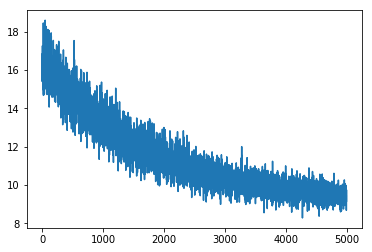

In [19]:
plt.plot(train_loss_history)

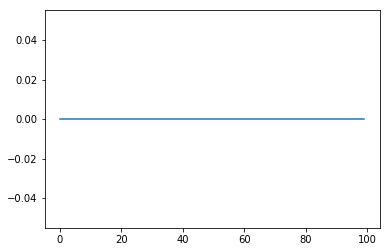

In [107]:
plt.plot(test_loss_history)

### Accuracy

In [20]:
# y_train_preds = svm_nl.forward(X_train, X_train, co_eff)
y_test_preds = svm_nl.forward(X_batch, X_test, co_eff)

In [25]:
(y_test_preds == 0)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [21]:
# train_acc = svm.accuracy(y_train, y_train_preds)
train_acc = 0.0
test_acc = svm.accuracy(y_test, y_test_preds)
print(f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

train_acc=0.0000, test_acc=0.0980


### Kernal multiclass SVM

In [400]:
def hinge_loss(X, y, w, delta=1., reg=0.01, grad=True):
    """Cost sensitive multiclass categorization
    """
    n_samples = X.shape[0]
    scores = np.dot(X, w)
    correct_class_scores = scores[np.arange(n_samples), y].reshape(n_samples, 1)
    margin = np.maximum(0, scores - correct_class_scores + delta)
    # We do not want to consider correct class in loss 
    margin[np.arange(n_samples), y] = 0
    loss = margin.sum() / n_samples

    loss += reg * np.sum(w * w)
    
    if grad:
        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract incorrect class (-s_y)
        margin[np.arange(n_samples), y] = -valid_margin_count
        dW = (X.T).dot(margin) / n_samples

        # Regularization gradient
        dW = dW + reg * 2 * w

        result = loss, dW
    else:
        result = loss
    return result

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

def predict(X, w):
    scores = X.dot(w)
    y_pred = scores.argmax(axis=1)
    return y_pred

def accuracy(y, y_preds):
    return np.mean(y == y_preds)

## Non-linear SVM

### Weston and Watkins

In [41]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a[:, None] - b)**2, axis=2))

def kernel(x1, x2, name="linear", d=2, gamma=10.):
    result = None
    if name == "linear":
        result = np.dot(x1, x2.T) # Linear kernel - same as np.inner(x, x.T)
    if name == "polynomial":
        result = (1 + np.dot(x1, x2.T))**d
    elif name == "rbf":
        result = np.exp(-gamma * euclidean_distance(x1, x2)**2)
        
    return result

def hinge_loss_non_linear(X1, X2, y, w, kernel_name="rbf", delta=1., reg=0.01, grad=True):
    n_samples = X1.shape[0]
    batch_size = w.shape[0]
    
    # Compute for the scores
    k = kernel(X1, X2, name=kernel_name)
    scores = k.T.dot(w)
    # Record the score of the example's correct class
    correct_class_scores = scores[np.arange(n_samples), y]
    # Compute for the margin by getting the max between 0 and the computed expression
    margin = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + delta)
    # We do not want to consider correct class in loss 
    margin[np.arange(n_samples), y] = 0
    loss = margin.sum() / n_samples

    loss += reg * np.sum(w * w)
    
    if grad:
        # This mask can flag the examples in which their margin is greater than 0
        X_mask = np.zeros(margin.shape)
        X_mask[margin > 0] = 1
        # We count the number of these examples where margin > 0
        valid_margin_count = margin.sum(axis=1)
        # Subtract incorrect class (-s_y)
        X_mask[np.arange(n_samples), y] = -valid_margin_count
        # print(k.shape, k.shape, margin.shape)
        dW = (k.T).dot(X_mask) / n_samples

        # Regularization gradient
        dW = dW + reg * 2 * w

        result = loss, dW
    else:
        result = loss
    return result

### Train

With replacement means the same item can be chosen more than once. Without replacement means the same item cannot be selected more than once. 10 X 10 X 10 X 10 = 10,000 combinations are possible.

In [305]:
train_loss_history = []
test_loss_history = []
for epoch in range(epochs):
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    loss, dW = hinge_loss_non_linear(X_batch, X_batch, y_batch, co_eff, kernel_name="rbf", reg=C)
    # test_loss = hinge_loss_non_linear(X_batch, X_test, y_test, co_eff, kernel_name="rbf", grad=False)
    train_loss_history.append(loss)
    # test_loss_history.append(test_loss)
    co_eff = co_eff - alpha * dW
    
    if epoch % 100 == 0:
        print(f"epoch={epoch}/{epochs}, train_loss={loss}")

epoch=0/2000, train_loss=5792.116360572589
epoch=100/2000, train_loss=110.2688657319192
epoch=200/2000, train_loss=10.749742785975503
epoch=300/2000, train_loss=9.028847391989533
epoch=400/2000, train_loss=9.000744854343166
epoch=500/2000, train_loss=9.000298833755556
epoch=600/2000, train_loss=9.000281483721704
epoch=700/2000, train_loss=9.000403577023143
epoch=800/2000, train_loss=8.999937950148874
epoch=900/2000, train_loss=9.00000394307417
epoch=1000/2000, train_loss=8.999613973889003
epoch=1100/2000, train_loss=9.000359832512359
epoch=1200/2000, train_loss=9.000426056796188
epoch=1300/2000, train_loss=9.000384206649839
epoch=1400/2000, train_loss=8.999948659147353
epoch=1500/2000, train_loss=8.999865566906584
epoch=1600/2000, train_loss=9.000589803356226
epoch=1700/2000, train_loss=8.999688055457392
epoch=1800/2000, train_loss=9.000023393326332
epoch=1900/2000, train_loss=9.001008509955396


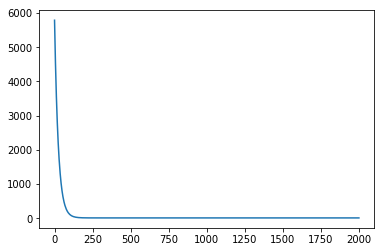

In [306]:
plt.plot(train_loss_history)

In [289]:
k = kernel(X_batch, X_test)

In [294]:
k.shape, co_eff.shape

((64, 10000), (64, 10))

In [296]:
np.dot(k.T, co_eff).shape

(10000, 10)

In [309]:
def predict_nl(x1, x2, w):
    k = kernel(x1, x2, name="rbf")
    scores = k.T.dot(w)
    y_pred = scores.argmax(axis=1)
    return y_pred

In [313]:
y_preds = predict_nl(X_batch, X_test, co_eff)

In [316]:
k = kernel(X_batch, X_test, name="rbf")
scores = k.T.dot(co_eff)

In [314]:
accuracy(y_test, y_preds)

0.098